# Laboratorio 2 - Clasificación y Regresión

En este laboratorio trabajaremos con algoritmos de clustering y reglas de asociación sobre 3 datasets:

1. __E-Commerce Data:__ Este dataset contiene transacciones realizadas por una empresa de e-commerce en distintos paises. Lo puede encontrar en el siguiente [link](https://www.kaggle.com/datasets/carrie1/ecommerce-data)
2. __Bank Customer Churn:__ Este dataset contiene información de clientes de un banco, dentro de esta base se encuentran tanto clientes fugados como no fugados. Puede encontrar el dataset en el siguiente [link](https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn)
3. __Global poverty and inequality dataset:__ Este daataset contiene información socio-demográfica proveniente del banco mundial referente a varios paises. Puede encontrar el dataset en el siguiente [link](https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset?select=pip_dataset.csv)


In [1]:

%pip install seaborn

In [2]:
import opendatasets as od
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


import numpy as np

import scipy
from scipy.stats import gaussian_kde

In [3]:
"""Descargamos los datasets
od.download("https://www.kaggle.com/datasets/carrie1/ecommerce-data")
od.download("https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn")
od.download("https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset?select=pip_dataset.csv")
"""

'Descargamos los datasets\nod.download("https://www.kaggle.com/datasets/carrie1/ecommerce-data")\nod.download("https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn")\nod.download("https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset?select=pip_dataset.csv")\n'

In [4]:
#Cargar csv's
bank_df= pd.read_csv("bank-customer-churn/Customer-Churn-Records.csv")
ecom_df=df = pd.read_csv("ecommerce-data/data.csv", encoding= 'unicode_escape')
poverty_df= df = pd.read_csv("global-poverty-and-inequality-dataset/pip_dataset.csv")


# Preguntas

## 1. Bank Customer Churn (35 pts)
Es de interés saber qué perfil tienen los clientes que más se fugan del banco y aquellos que son más leales (menos fuga). Resuelva este problema usando modelos de clustering y posteriormente ajuste algún modelo de clasificación, validándolos según las métricas vistas en clases para ambos tipos de problemas. Discuta el desempeño por separado de ambos modelos en su respectivo problema y discuta con qué aproximación se quedaría usted para reportar los perfiles. ¿Cómo describiría usted los perfiles encontrados? (si son muchos basta discutir los que poseen mayor cantidad de elementos).



In [5]:
bank_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# Limpieza del dataset

In [6]:
bank_df.columns = [i.lower().replace(' ','_') for i in bank_df.columns]

In [7]:
print("Tiene algun elemento vacio? : {}".format(bank_df.isnull().any().any()))

Tiene algun elemento vacio? : False


In [8]:
# Drop unnecessary columns
bank_df = bank_df.drop(columns = ['rownumber','customerid'])

In [9]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surname             10000 non-null  object 
 1   creditscore         10000 non-null  int64  
 2   geography           10000 non-null  object 
 3   gender              10000 non-null  object 
 4   age                 10000 non-null  int64  
 5   tenure              10000 non-null  int64  
 6   balance             10000 non-null  float64
 7   numofproducts       10000 non-null  int64  
 8   hascrcard           10000 non-null  int64  
 9   isactivemember      10000 non-null  int64  
 10  estimatedsalary     10000 non-null  float64
 11  exited              10000 non-null  int64  
 12  complain            10000 non-null  int64  
 13  satisfaction_score  10000 non-null  int64  
 14  card_type           10000 non-null  object 
 15  point_earned        10000 non-null  int64  
dtypes: fl

In [10]:
df = bank_df.sample(10)

# Separamos las columnas para graficarlas y hacer un EDA
col_cat = df.select_dtypes('object')
col_cat = col_cat[['geography','gender','card_type']]
num_col = df.select_dtypes(['int64','float64'])   


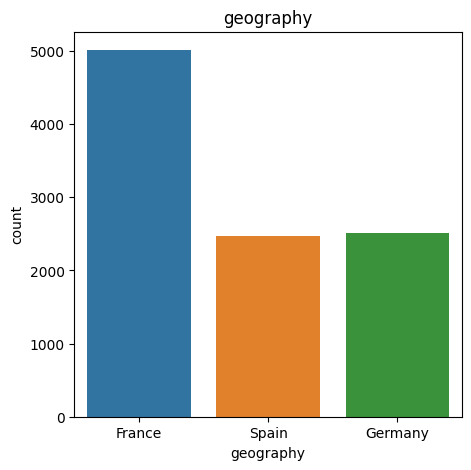

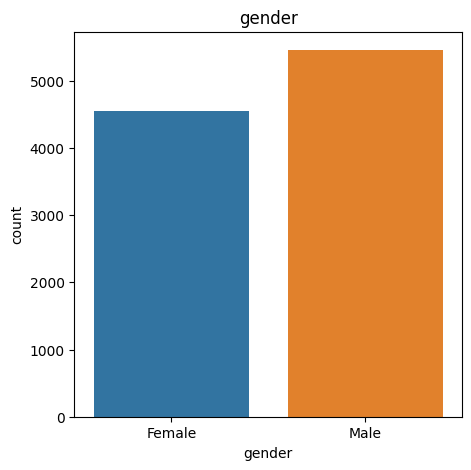

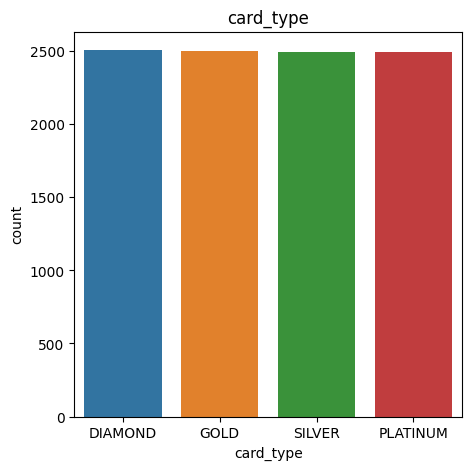

In [11]:
# Contadores de las columnas categoricas

for i in col_cat:
    plt.figure(figsize = (5,5))
    sns.countplot(bank_df, x = i)
    plt.title(i)
    plt.show()

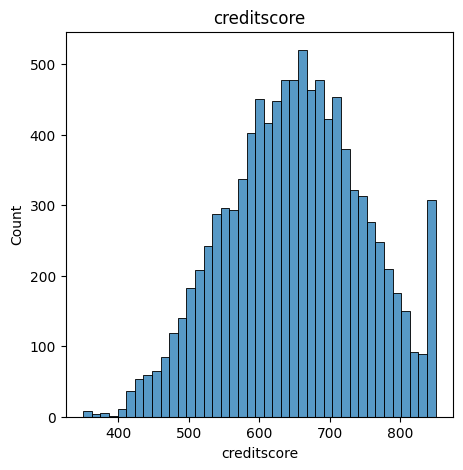

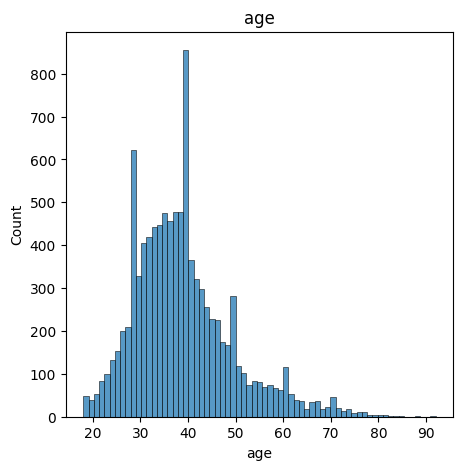

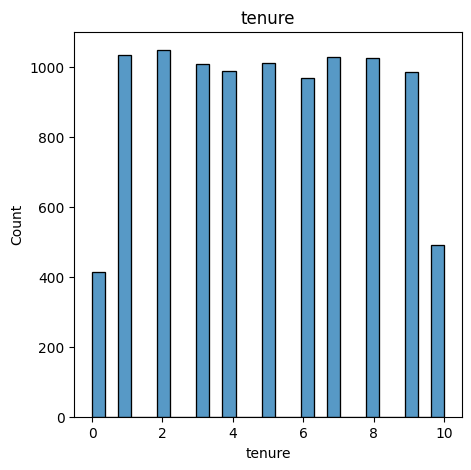

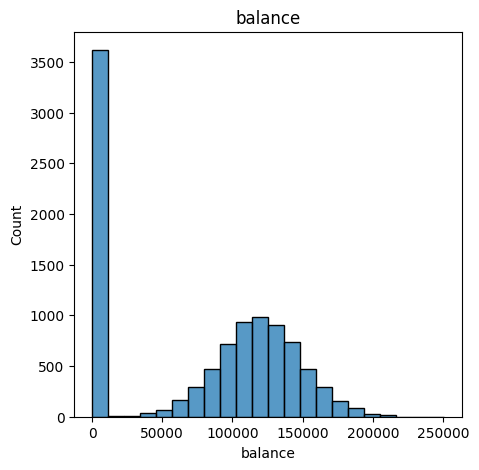

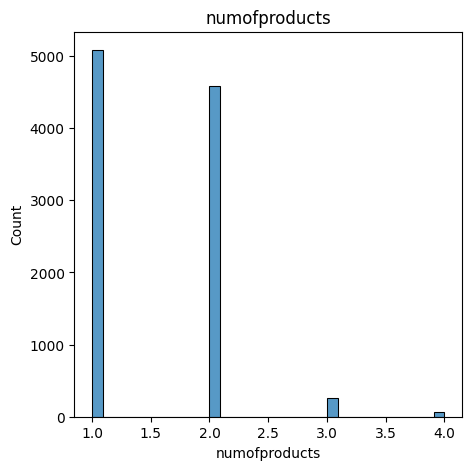

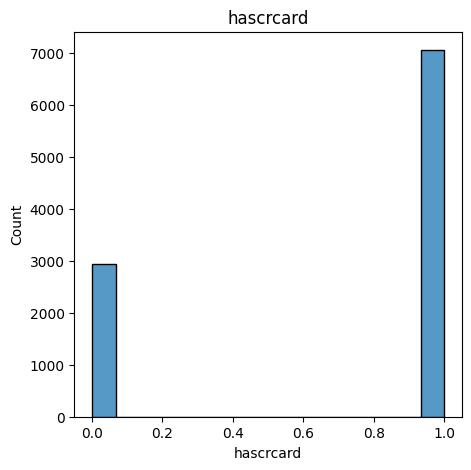

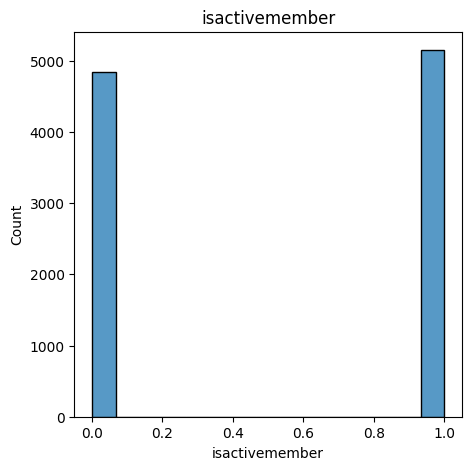

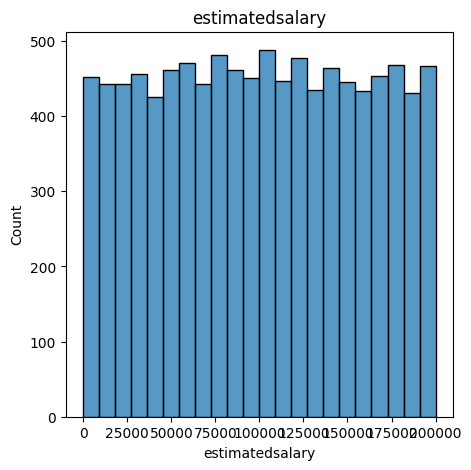

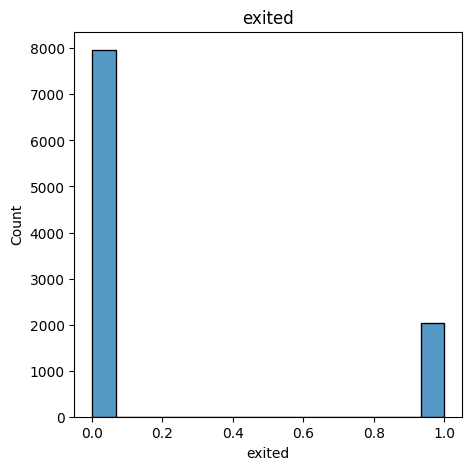

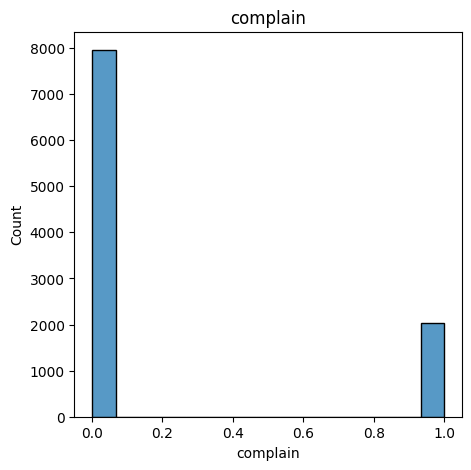

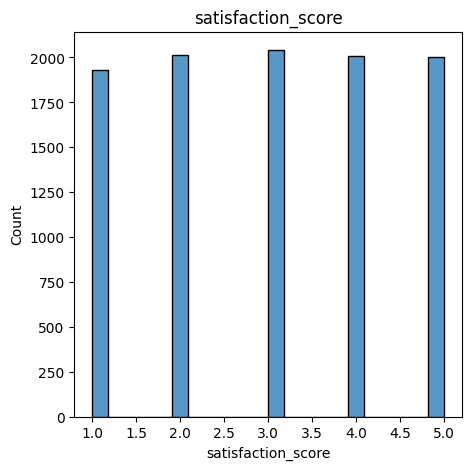

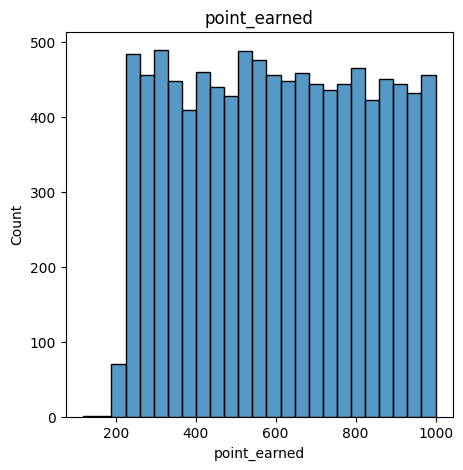

In [12]:
# Columnas numericas


for i in num_col:
    plt.figure(figsize = (5,5))
    sns.histplot(bank_df, x = i)
    plt.title(i)
    plt.show()

## EDA

IDea principal:
Buscar 2 columnas DISTINTAS A EXITED para clusterizar
Luego probar si esos patrones de clasificacion tienen mayor cantidad de exited.

Colunas encontradas interesantes: 

- CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- Geography—a customer’s location can affect their decision to leave the bank
Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
IsActiveMember—active customers are less likely to leave the bank.
EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.


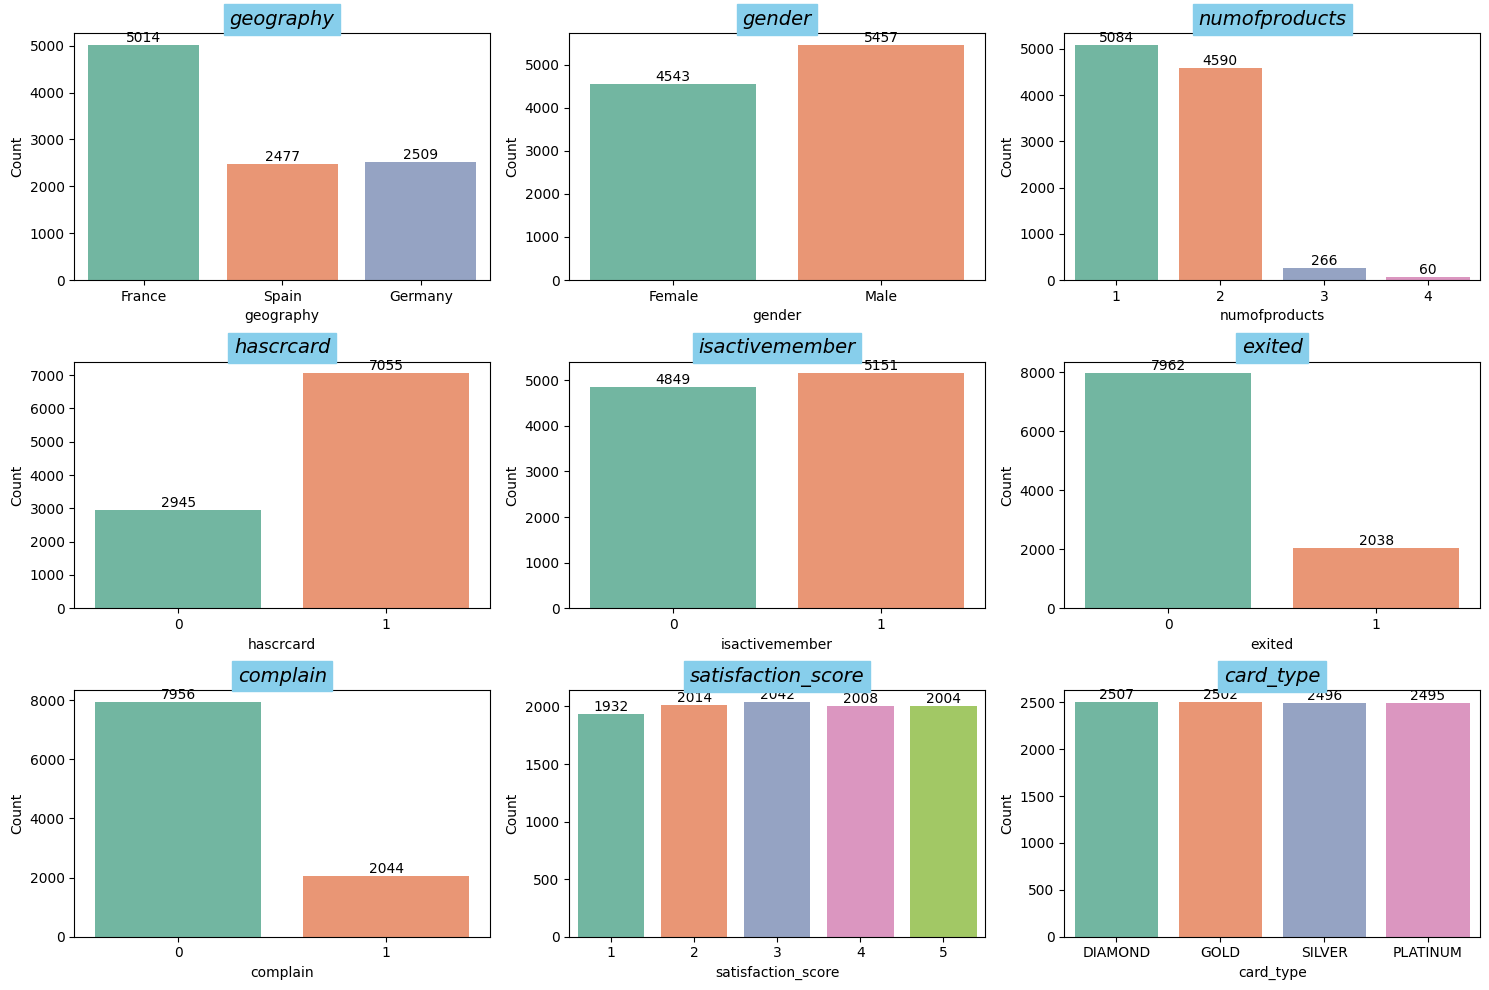

In [13]:
# Take a quick look at categorical features and feature with discrete values
feature = ['geography', 'gender', 'numofproducts', 'hascrcard', 'isactivemember', 'exited', 'complain', 'satisfaction_score', 'card_type']

fig = plt.figure(figsize = (15,10))

for i,j in enumerate(feature):
    ax = fig.add_subplot(3,3,i+1)
    ax = sns.countplot(bank_df , x = j , palette = sns.color_palette("Set2"))
    ax.set_title(j , fontsize = 14 , style = 'italic', backgroundcolor = 'skyblue')
    ax.set_ylabel('Count')
    ax.bar_label(ax.containers[0], label_type='edge')
plt.tight_layout()    
plt.show()    

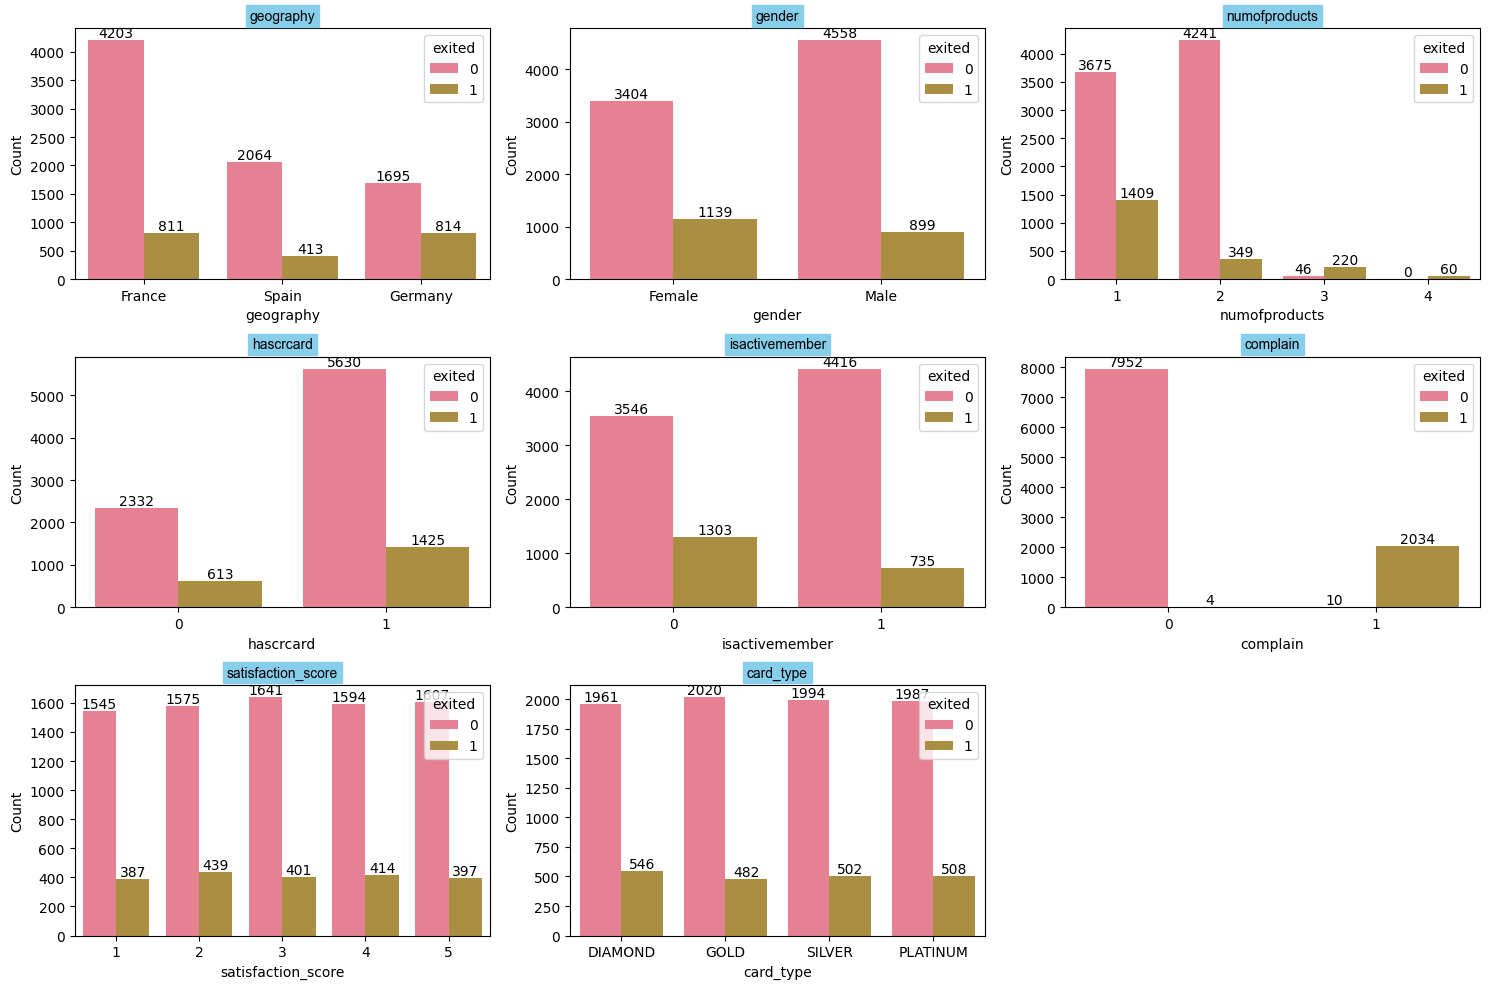

In [14]:
# Take a quick look at some features by churn
# 0 means not change and 1 means change
feature = ['geography', 'gender', 'numofproducts', 'hascrcard', 'isactivemember', 'complain', 'satisfaction_score', 'card_type']

fig = plt.figure(figsize = (15,10))

for i,j in enumerate(feature):
    ax = fig.add_subplot(3,3,i+1)
    ax = sns.countplot(bank_df , x = j , hue = 'exited' , palette = sns.color_palette('husl') )
    ax.set_title(j , fontsize = 15 , style = 'italic' , backgroundcolor = 'skyblue', font = 'Arial')
    ax.set_ylabel('Count')
    ax.bar_label(ax.containers[0],label_type='edge')
    ax.bar_label(ax.containers[1],label_type='edge')
plt.tight_layout()    
plt.show()    

C:\Users\n3mes\AppData\Local\Temp\ipykernel_32824\2009193845.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(bank_df, x = j ,kde = True, palette = 'pastel')
C:\Users\n3mes\AppData\Local\Temp\ipykernel_32824\2009193845.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(bank_df, x = j ,kde = True, palette = 'pastel')
C:\Users\n3mes\AppData\Local\Temp\ipykernel_32824\2009193845.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(bank_df, x = j ,kde = True, palette = 'pastel')


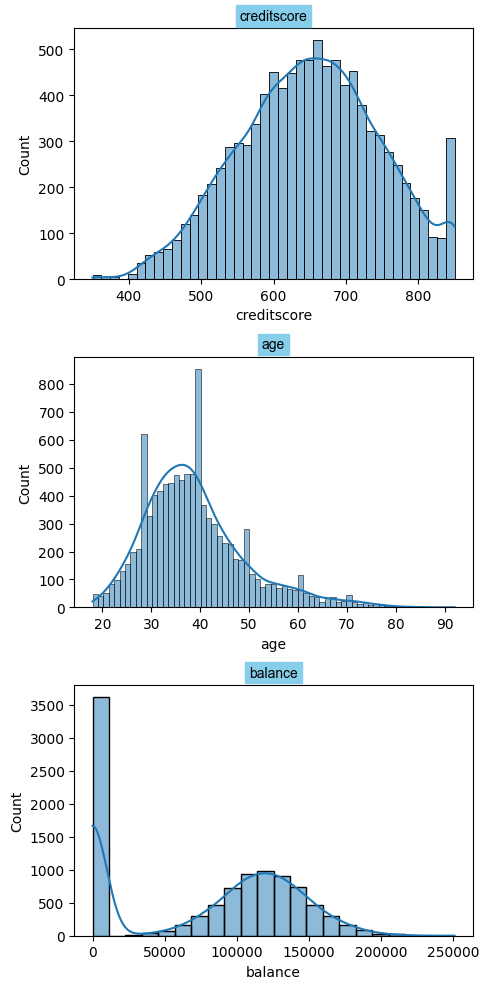

In [15]:
# Take a look at continous features
feat = ['creditscore','age','balance']

fig = plt.figure(figsize = (5,10))

for i,j in enumerate(feat):
    ax = fig.add_subplot(3,1,i+1)
    ax = sns.histplot(bank_df, x = j ,kde = True, palette = 'pastel')
    ax.set_title(j , fontsize = 15 , style = 'italic' , backgroundcolor = 'skyblue', font = 'Arial')
    ax.set_ylabel('Count')
    
plt.tight_layout()      
plt.show() 

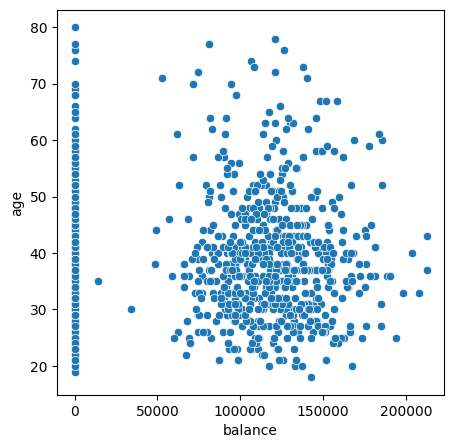

In [16]:
df = bank_df.sample(1000)

fig = plt.figure(figsize = (5,5))
ax = sns.scatterplot(df, x="balance", y = "age")


# No hay gente de alemania con balance 0?

In [17]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


<Axes: xlabel='age', ylabel='estimatedsalary'>

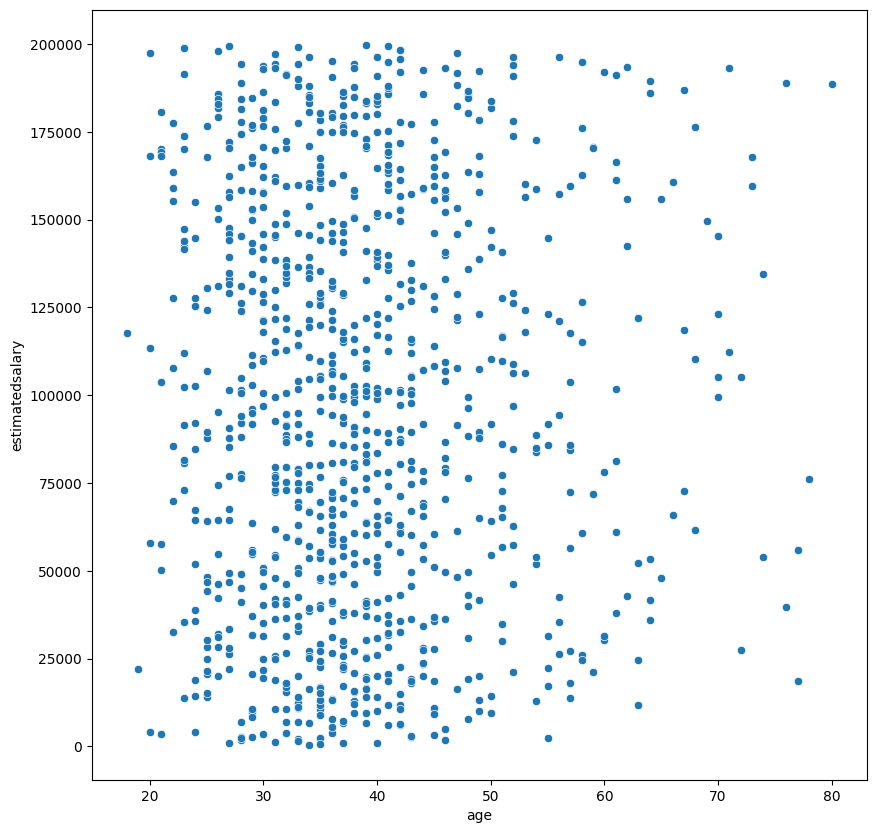

In [18]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(df, x="age", y = "estimatedsalary")

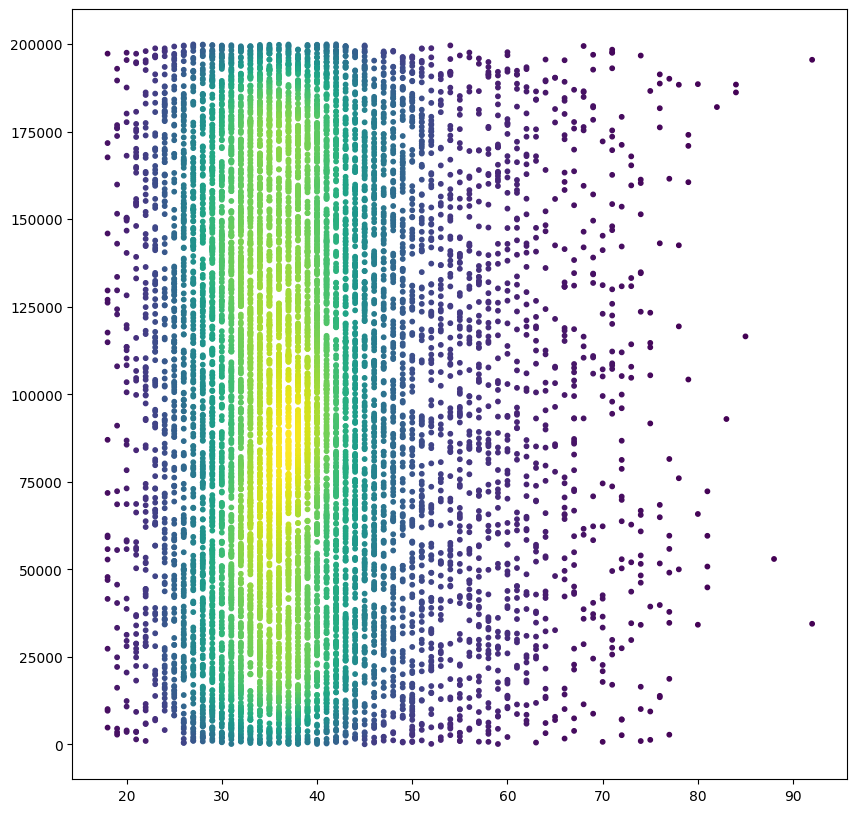

In [19]:



x = bank_df["age"]
y = bank_df["estimatedsalary"]



# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(x, y, c=z, s=10)
plt.show()

In [22]:
%pip install scikit-learn


     ---------------------------------------- 8.3/8.3 MB 11.5 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 9.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## KMEANS method 

Cosas que podemos hacer:
- Hacer una funcion que copie el dataframe, y reciba un k = K para crear el kmeans clustering, y que imprima los scatter plot necesarios para mostrar esa division
- Copiar el dataframe
- Predecir con km.fit_predict
- Agregar columna a copia de df
- Opcion 1: Devolver el dataframe (y llamar una funcionq ue printee)
- Opcion 2: Producir el gráfico.

Ojalá la funcion retorne las metricas de kmeans tambien.

In [23]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


km = KMeans(n_clusters=3)
km

KMeans(n_clusters=3)

In [29]:
y_predicted = km.fit_predict(bank_df[["age", "estimatedsalary"]])
y_predicted

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([2, 2, 2, ..., 1, 2, 1])

In [30]:
bank_df["cluster"] = y_predicted
bank_df.head()

,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction_score,card_type,point_earned,cluster
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464,2
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456,2
2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377,2
3,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350,2
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425,2


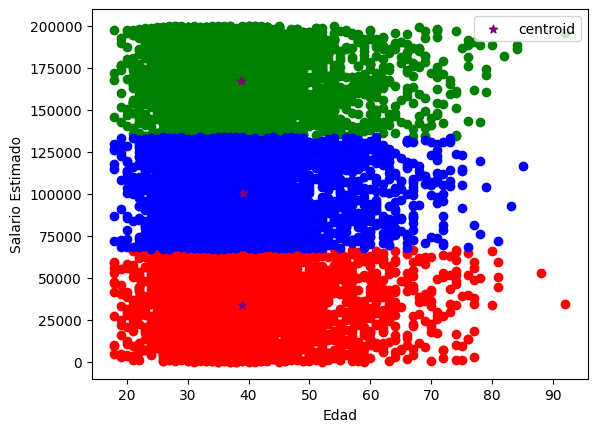

In [32]:
df1 = bank_df[bank_df.cluster==0]
df2 = bank_df[bank_df.cluster==1]
df3 = bank_df[bank_df.cluster==2]


plt.scatter(df1.age, df1["estimatedsalary"], color="green")
plt.scatter(df2.age, df2["estimatedsalary"], color="red")
plt.scatter(df3.age, df3["estimatedsalary"], color="blue")
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color="purple", marker="*", label="centroid")
plt.xlabel("Edad")
plt.ylabel("Salario Estimado")
plt.legend()


<Axes: xlabel='age', ylabel='estimatedsalary'>

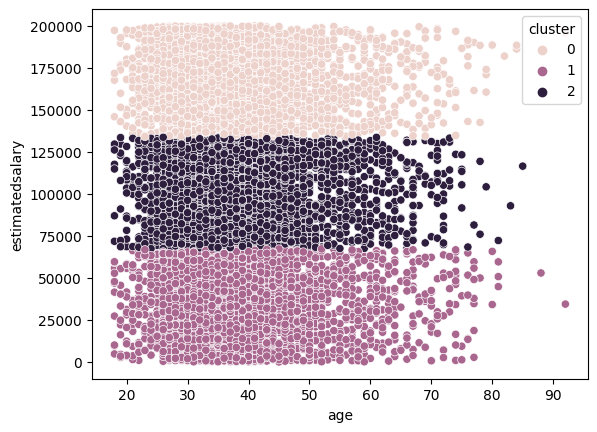

In [35]:
sns.scatterplot(bank_df, x="age", y="estimatedsalary", hue="cluster")

Ideas que estamos barajando:

- comparaciones entre columnas para buscar si algo es determinante
    - Satisfaction v/s Gender
    - Balance v/s Estimated Salary -> Creo que es la menos viable
    - Complain v/s satisfaction score
    - Card type v/s satisfaction score
    - Point Earned v/s Card Type
    - Point Earned v/s balance


In [ ]:
# Existe alguna relacion entre el score de satisfaccion y el exited? 

x = bank_df["Satisfaction Score"]
y = bank_df["Exited"]


plt.scatter(x,y,  cmap="viridis")


KeyError: 'Satisfaction Score'

In [ ]:
#plt.scatter(bank_df['CreditScore'], bank_df['Exited'])
print(bank_df[["Geography", "Exited"]].groupby("Geography").count()) # cuantas personas de cada pais se van
print(bank_df[["Gender", "Exited"]].groupby("Gender").count()) # cuantas personas por genero se van
print("\n")
print(bank_df['Age'].describe()) # Edad de las personas
print("\n")
print(bank_df['Tenure'].describe()) # Distribución del tiempo que llevan en el banco




In [ ]:
# Existe algun valor del balance que indique que se fueron?

bank_df[["Balance", "Exited"]].groupby("Balance").describe()


In [ ]:
# Existe un salario representativo para la gente que se va?
# Los grupos de las personas que se van tienen X plata...

bank_df[["EstimatedSalary", "Exited"]].groupby("EstimatedSalary").describe()

In [ ]:
distribucionPorEdad= bank_df.groupby('Age')['Exited'].mean()*100
print(distribucionPorEdad)
print(type(distribucionPorEdad))

In [ ]:
valores_filtrados = bank_df.loc[bank_df['Age'] ==88, 'Exited']
print(valores_filtrados)

In [ ]:
import pandas as pd

# Crear un DataFrame de ejemplo
data = {'columna_a': [10, 20, 30, 40, 50],
        'columna_b': [100, 200, 300, 400, 500]}
df = pd.DataFrame(data)

# Definir un umbral
umbral = 30

# Mostrar los valores de 'columna_b' cuando 'columna_a' sea mayor que el umbral
valores_filtrados = df.loc[df['columna_a'] > umbral, 'columna_b']

# Imprimir los valores filtrados
print(valores_filtrados)

## 2. Global Poverty and Inequality Dataset (35 pts)
Suponga que le solicitan generar una categorización de paises de acuerdo a sus características socio-demográficoas y socio-económicas en 5 grupos, aplique los métodos de clustering para clusterizar la información de los paises:



> ##### __2.1)__ De acuerdo a su experimentación, ¿es razonable hacer la categorización en 5 grupos para ese conjunto de datos o sugeriría una cantidad distinta?, fundamente experimentalmente su respuesta. (15 pts)
>


> ##### __2.2)__ De acuerdo a la cantidad escogida por usted en la pregunta anterior (ya sea que decidió quedarse con los 5 o una cantidad distinta) haga un análisis de los clusters explique qué características tienen los distintos grupos de paises encontrados. (10 pts)
>


> ##### __2.3)__ Muestre en un mapa del mundo la distribución de los clusters pintando cada país con el color correspondiente al cluster al que pertenece, ¿ve algún patrón? (le será útil usar la librería `geopandas`, acá un ejemplo de como usarla: [link](https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b)) (10 pts)

__Nota:__ Cuando explore el dataset se dará cuenta que cada país no aparece solo una vez sino que varias veces de acuerdo a cada año del cuál se tiene registro, trate esta información temporal como usted estime conveniente para poder resolver el problema enunciado al principio justificando su decisión.



## 3. E-Commerce Data (30)
Aplique el algoritmo apriori (puede encontrar una buena implementación en la librería `mlxtend`) sobre el conjunto de transacciones y obtenga los 100 itemsets más significativos.


Tenga en cuenta lo siguiente:

* Cada fila es un evento de compra/devolución de un producto realizado por un cliente, para evitar trabajar con las devoluciones elimine todas aquellas filas que contengan valores negativos de `Quantity` y `UnitPrice`.
* En el método apriori de `mlxtend` se pide que las transacciones sean procesadas con un transformador llamado `TransactionEncoder` el cual requiere que los conjuntos de articulos comprados en en una misma transaccion se presenten como una lista de productos, acá hay un ejemplo de dos transacciones en el formato requerido:
```
[['pan', 'mantequilla', 'mermelada'],
['trapero', 'lavaloza', 'polera', 'pantalon', 'cereales']]
```
Para poder hacer esto necesitará "agrupar" los elementos comprados según el código de la boleta (`InvoiceNo`).
* En las transacciones realizadas hay varios errores de ingreso del código del producto y la descripción del mismo, específicamente el problema está en que hay casos donde un código de producto está ligado a más de una descripción, sin embargo, solo una de las descripciones es la correcta: La más común, acá un par de ejemplos:



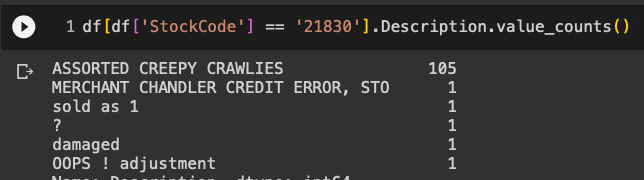




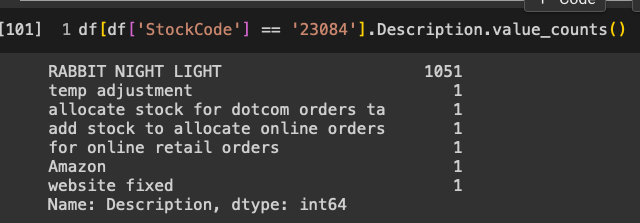

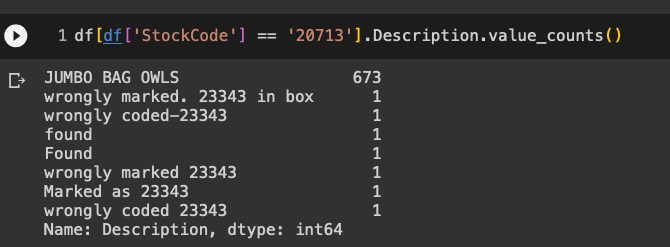

Preprocese adecuadamente las transacciones para quedarse solo con aquellas transacciones que tengan, para cada código de producto, la descripción más común encontrada para ese código. __No realizar esto implicará caer en una penalización de 15 pts.__

In [ ]:
print(ecom_df.head())

In [ ]:
negativePrice_df= ecom_df[ecom_df['UnitPrice']<=0] #Veremos cuantas filas tienen registros de precios=0 o negativos
negativePrice_df

In [ ]:
negativeQuantity_df= ecom_df[ecom_df['Quantity']<=0] #Revisamos cuantas filas tienen cantidades de prod<=0
negativeQuantity_df

In [ ]:

plt.scatter(ecom_df['Quantity'], ecom_df['UnitPrice'])